<center><h1>Xian_Junyan_HW2</h1></center>
<br>
<br>

Name: Junyan Xian
<br>
Github Username: JunyanXian97
<br>
USC ID: 5625653569

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1010]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


Get the Cycle Power Plant Data Set

In [1013]:
df = pd.read_excel('../data/Folds5x2_pp.xlsx', sheet_name=0)  
print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


### (b) Exploring the data

#### i. rows and columns

In [1017]:
row = len(df.axes[0])
print("Number of Rows: ", row)
col = len(df.axes[1])
print("Number of Columns: ", col)

Number of Rows:  9568
Number of Columns:  5


The rows represent data points from Combined Cycle Power Plant and the columns represent variables: hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant.

#### ii. pairwise scatterplots of all the varianbles

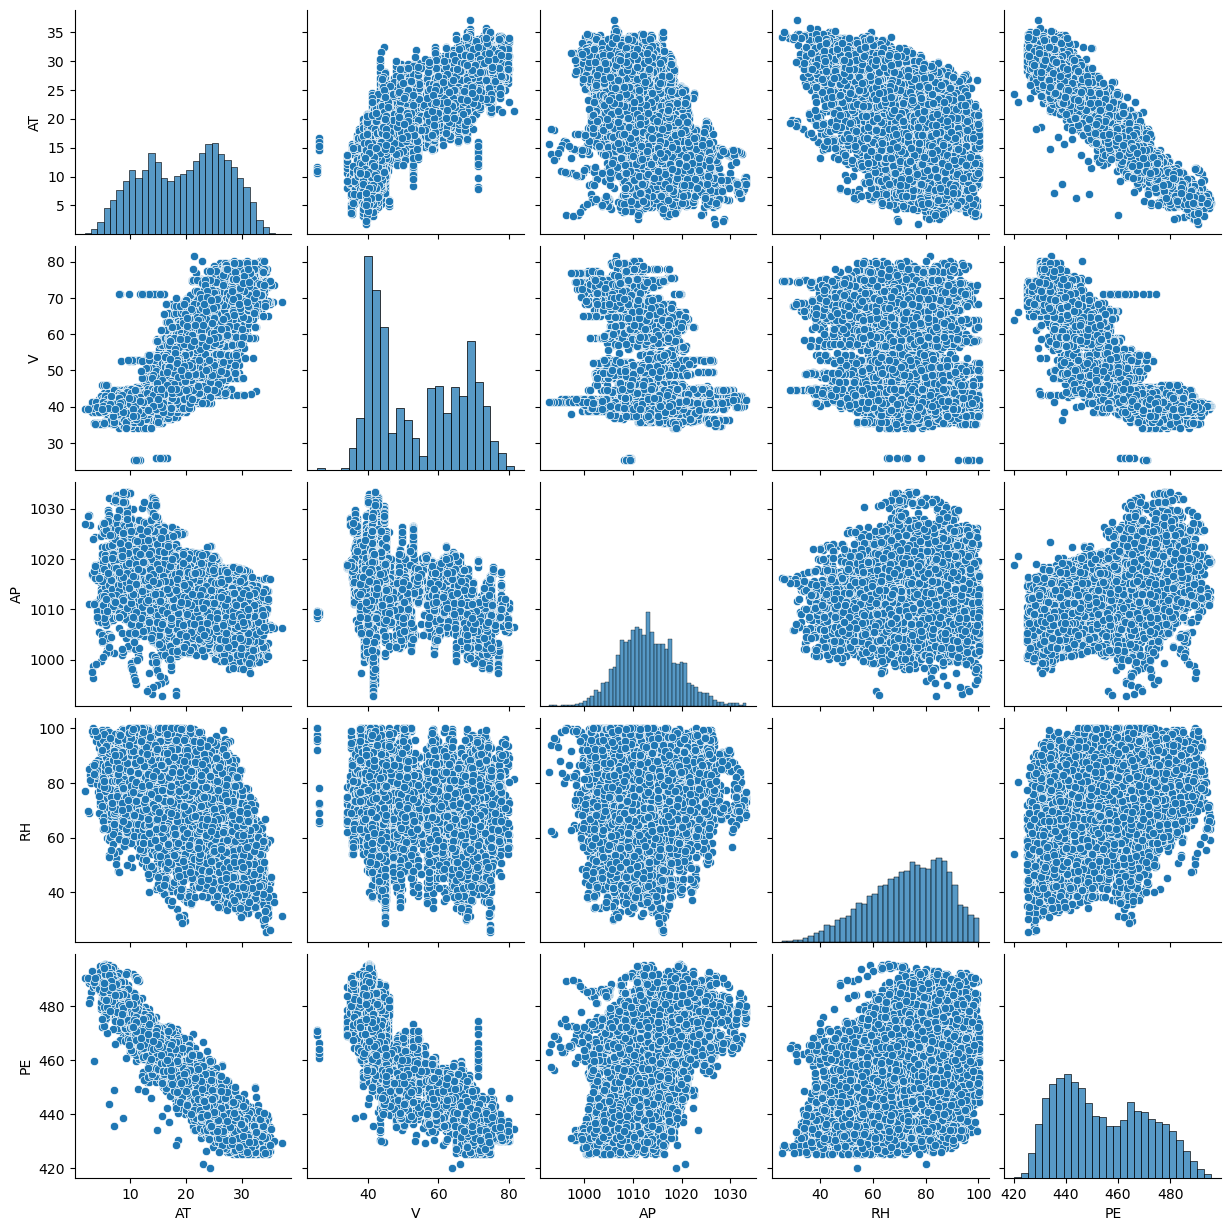

In [1021]:
sns.pairplot(df) 

From the pairplot, there are some negative correlation and positive corrections:<br> 
negative correlation:<br>
AT and PE<br>
V and PE<br>
<br>
positive correlation:<br>
AT and V<br>


#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [1025]:
summary = df.describe().T
summary['median'] = df.median()
summary['range'] = summary['max'] - summary['min']
summary['IQR'] = summary['75%'] - summary['25%']
summary = summary[['mean', 'median', 'range','25%', '75%', 'IQR']]
print(summary)



           mean    median  range        25%      75%      IQR
AT    19.651231    20.345  35.30    13.5100    25.72  12.2100
V     54.305804    52.080  56.20    41.7400    66.54  24.8000
AP  1013.259078  1012.940  40.41  1009.1000  1017.26   8.1600
RH    73.308978    74.975  74.60    63.3275    84.83  21.5025
PE   454.365009   451.550  75.50   439.7500   468.43  28.6800


### (c) Simple Linear Regression

All models have statistically significant association between the predictor and the respons because P-value is less than 0.05. According to the scatterplots, the predictor and the respons has a linear regression trend. Points (outliers) that far away from the general pattern of fitted line should be removed from the data.  

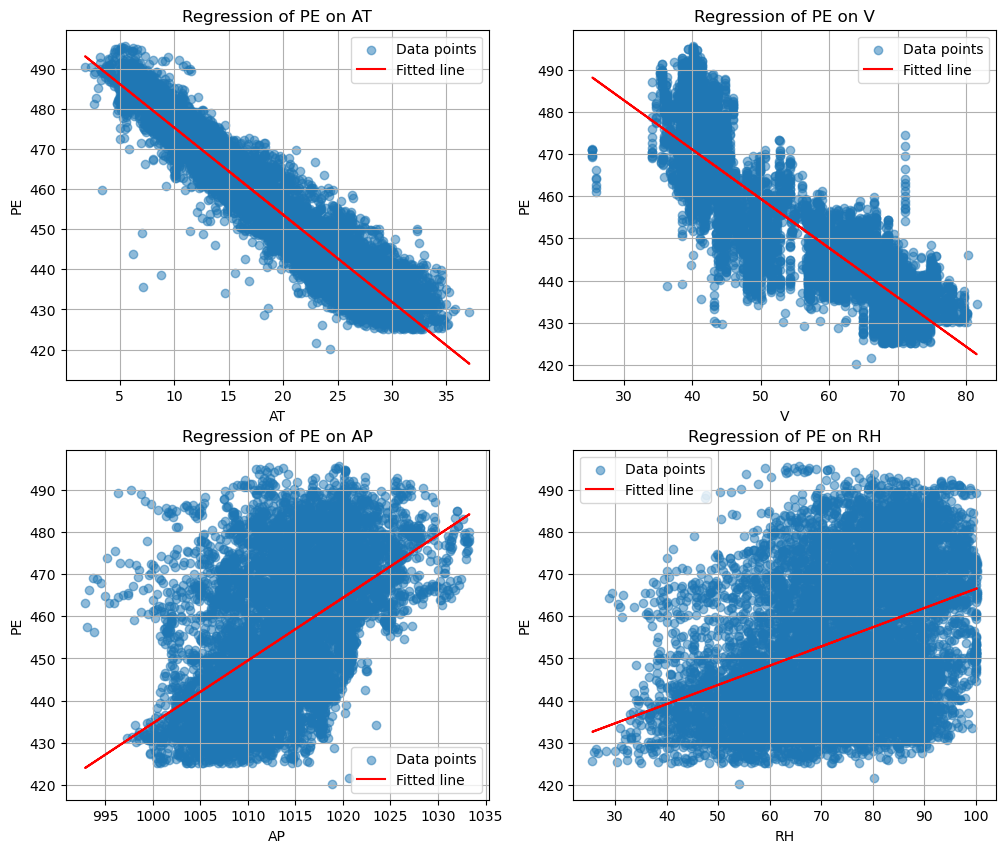

Results for AT:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:54:48   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3

In [1069]:
results_summaries = {}


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()  

for i, x in enumerate(df.columns[:-1]):  
    X = sm.add_constant(df[x]) 
    Y = df['PE']               
    model = sm.OLS(Y, X) 
    results = model.fit()
    results_summaries[x] = results.summary()  
    axes[i].scatter(df[x], Y, alpha=0.5, label='Data points')
    y_fit = results.predict(X)  
    axes[i].plot(df[x], y_fit, color='red', label='Fitted line')
    axes[i].set_xlabel(x)  
    axes[i].set_ylabel('PE')
    axes[i].set_title(f'Regression of PE on {x}')
    axes[i].legend()
    axes[i].grid()
plt.show()
for x, summary in results_summaries.items():
    print(f"Results for {x}:\n{summary}\n")


### (d) Multiple Regression

We can reject the null hypothesis for all predictors becuase p-value is lower than 0.05 for all predictors. 

In [908]:
Y = df['PE'] 
X = df.iloc[:, :-1]  

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:27:34   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

### (e) 1c Compare to 1d

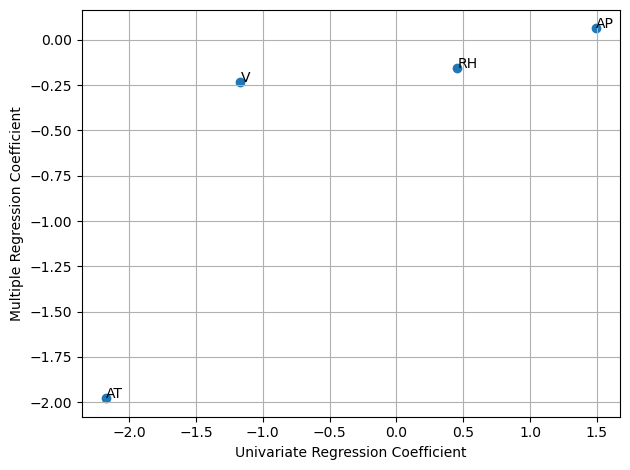

In [911]:
uni_coe = {}

for predictor in df.columns[:-1]:  
    X_uni = sm.add_constant(df[predictor])
    Y = df['PE']
    
    model_uni = sm.OLS(Y, X_uni)
    
    results_uni = model_uni.fit()
    
    uni_coe[predictor] = results_uni.params.iloc[1]  


X_multi = df.iloc[:, :-1]  
X_multi = sm.add_constant(X_multi)  
Y = df['PE']
model_multi = sm.OLS(Y, X_multi)
results_multi = model_multi.fit()
multi_coe = results_multi.params[1:]  


comparison_df = pd.DataFrame({'Predictor': uni_coe.keys(), 
                              'Univariate Coefficient': uni_coe.values(), 
                              'Multiple Coefficient': multi_coe.values})


plt.scatter(comparison_df['Univariate Coefficient'], comparison_df['Multiple Coefficient'])
plt.xlabel('Univariate Regression Coefficient')
plt.ylabel('Multiple Regression Coefficient')

for i, txt in enumerate(comparison_df['Predictor']):
    plt.annotate(txt, (comparison_df['Univariate Coefficient'].iloc[i], comparison_df['Multiple Coefficient'].iloc[i]))

plt.grid()
plt.tight_layout()
plt.show()


### (f) Nonlinear Association

In [914]:
Y = df['PE']  
results = {}

for predictor in df.columns[:-1]:  
    X = df[[predictor]]  
    
    poly = PolynomialFeatures(degree=(2,3), interaction_only=False, include_bias=True)
    
    X_poly = poly.fit_transform(X)
    
   
    model = sm.OLS(Y, X_poly)
    results_poly = model.fit()
    
    results[predictor] = results_poly.summary()
    
    print(f"Results for {predictor}:")
    print(results[predictor])
    print("\n")


Results for AT:
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 4.935e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:27:36   Log-Likelihood:                -29113.
No. Observations:                9568   AIC:                         5.823e+04
Df Residuals:                    9565   BIC:                         5.825e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        489.4957      0.158   3

### (g) Interactions of Predictors

In [917]:
df['AT_AP'] = df['AT'] * df['AP']
df['AT_RH'] = df['AT'] * df['RH']
df['AT_V'] = df['AT'] * df['V']
df['AP_RH'] = df['AP'] * df['RH']
df['AP_V'] = df['AP'] * df['V']
df['RH_V'] = df['RH'] * df['V']

df['AT_AP_V'] = df['AT'] * df['AP'] * df['V']
df['AT_RH_AP'] = df['AT'] * df['RH'] * df['AP']
df['AT_V_RH'] = df['AT'] * df['V'] * df['RH']
df['AP_RH_V'] = df['AP'] * df['RH'] * df['V']

df['AP_RH_V_AT'] = df['AP'] * df['RH'] * df['V'] * df['AT']

X_interaction = sm.add_constant(df[['AT', 'AP', 'RH', 'V', 
                                    'AT_AP', 'AT_RH', 'AT_V', 
                                    'AP_RH', 'AP_V', 'RH_V',
                                    'AT_AP_V', 'AT_RH_AP', 'AT_V_RH', 
                                    'AP_RH_V', 'AP_RH_V_AT']])

model_interaction = sm.OLS(y, X_interaction).fit()

print("Full Model with Interaction Terms")
print(model_interaction.summary())


Full Model with Interaction Terms
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     9568.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:27:37   Log-Likelihood:                -27450.
No. Observations:                9568   AIC:                         5.493e+04
Df Residuals:                    9552   BIC:                         5.505e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4433.5

### (h) Improvement

In [920]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

X_train = sm.add_constant(train_data[['AT', 'AP', 'RH', 'V']])
y_train = train_data['PE']

model_train = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(test_data[['AT', 'AP', 'RH', 'V']])
y_test = test_data['PE']

y_pred_test = model_train.predict(X_test)

print(model_train.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.194e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:27:38   Log-Likelihood:                -19630.
No. Observations:                6697   AIC:                         3.927e+04
Df Residuals:                    6692   BIC:                         3.930e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        467.8414     11.502     40.673      0.0

### (i) KNN

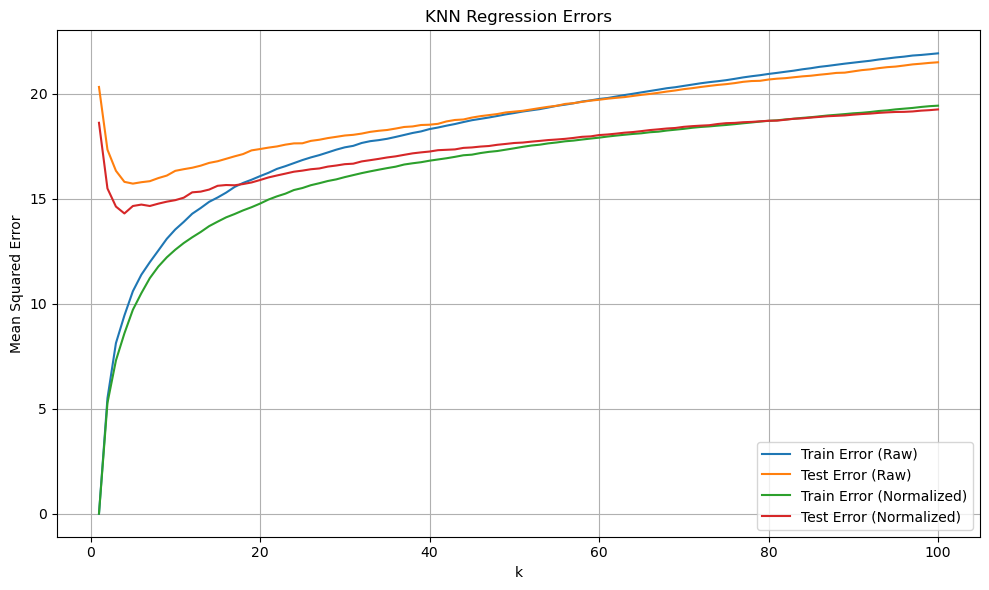

MIN Test Error (Raw): 15.726819842563568
MIN Test Error (Normalized): 14.305669422675024
Best K for KNN: 4


In [923]:
y = df['PE']  
X = df[['AT', 'AP', 'RH', 'V']]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

k_values = range(1, 101)
train_errors_raw = []
test_errors_raw = []
train_errors_norm = []
test_errors_norm = []

for k in k_values:
    knn_raw = KNeighborsRegressor(n_neighbors=k)
    knn_raw.fit(X_train[['AT', 'AP', 'RH', 'V']], y_train)
    train_errors_raw.append(np.mean((y_train - knn_raw.predict(X_train[['AT', 'AP', 'RH', 'V']])) ** 2))
    test_errors_raw.append(np.mean((y_test - knn_raw.predict(X_test[['AT', 'AP', 'RH', 'V']])) ** 2))

for k in k_values:
    knn_norm = KNeighborsRegressor(n_neighbors=k)
    knn_norm.fit(X_train_scaled, y_train) 
    train_errors_norm.append(np.mean((y_train - knn_norm.predict(X_train_scaled)) ** 2))
    test_errors_norm.append(np.mean((y_test - knn_norm.predict(X_test_scaled)) ** 2))

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_errors_raw, label='Train Error (Raw)')
plt.plot(k_values, test_errors_raw, label='Test Error (Raw)')
plt.plot(k_values, train_errors_norm, label='Train Error (Normalized)')
plt.plot(k_values, test_errors_norm, label='Test Error (Normalized)')
plt.xlabel("k")
plt.ylabel("Mean Squared Error")
plt.title("KNN Regression Errors")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

min_test_errors_raw = min(test_errors_raw)
min_test_errors_norm = min(test_errors_norm)


print(f"MIN Test Error (Raw): {min_test_errors_raw}")
print(f"MIN Test Error (Normalized): {min_test_errors_norm}")

best_k_index = np.argmin(test_errors_norm)  
best_k = k_values[best_k_index] 
print(f"Best K for KNN: {best_k}")


### (j ) Compare KNN and Linear

In [934]:
lin_reg_model = sm.OLS(y_train, X_train).fit()
lin_reg_test_error = mean_squared_error(y_test, lin_reg_model.predict(X_test))

print(f"Linear Regression Test Error: {lin_reg_test_error}")

Linear Regression Test Error: 25.09690117693232


Because KNN’s test error is lower than the linear regression test error, KNN is better at modeling the data.

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

A flexible statistical learning method will be better than an inflexible statisticla learning method. Larger n would provide more data to help fit the flexible learning method. 

### (b) The number of predictors p is extremely large, and the number of observations n is small.

A flexible statistical learning method will be worse than an inflexible statisticla learning method. When n is small, the flexible method will overfit. 

### (c) The relationship between the predictors and response is highly non-linear.

A flexible statistical learning method will be better than an inflexible statistical learning method. Flexible method adapt to the non-linear relationship while inflexible method adapt to the linear one. 

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

A flexible statistical learning method will be worse than an inflexible statisticla learning method. Error terms create noise to the flexible method which causes over-fitting. 

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [1056]:
def ed(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (point2[i] - point1[i]) ** 2
    return math.sqrt(distance)

o1= [0,3,0]
o2=[2,0,0]
o3=[0,1,3]
o4=[0,1,2]
o5=[1,0,1]
o6=[1,1,1]
test_point = [0,0,0]
d1 = ed(o1, test_point)
d2 = ed(o2, test_point)
d3 = ed(o3, test_point)
d4 = ed(o4, test_point)
d5 = ed(o5, test_point)
d6 = ed(o6, test_point)


data = {'observation': [1,2,3,4,5,6],
        'X1':[0,2,0,0,-1,1],
        'X2':[3,0,1,1,0,1],
        'X3':[0,0,3,2,1,1],
        'Y': ['Red', 'Red', 'Red', 'Green','Green','Red'],
        'Euclidean_distance':[d1,d2,d3,d4,d5,d6]}

training_df = pd.DataFrame(data)
print(traning_df)



   observation  X1  X2  X3      Y  Euclidean_distance
0            1   0   3   0    Red            3.000000
1            2   2   0   0    Red            2.000000
2            3   0   1   3    Red            3.162278
3            4   0   1   2  Green            2.236068
4            5  -1   0   1  Green            1.414214
5            6   1   1   1    Red            1.732051


### (b) What is our prediction with K = 1? Why?

The closest euclidean distance from the observationto the test point will be 1.414214, and its prediction is Green. Therefore, when k=1, the prediction is Green.

### (c) What is our prediction with K = 3? Why?

When k=3, three closest euclidean distance from the observationto the test point will be 1.414214(o5), 1.732051(o6), and 2.000000(02). Their prediction are Green, Red, Red. Therefore, when k=3, the prediction is most of the prediction Red.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

Small. If the bayes decision boundary is highly non-linear, it will cause overfit. Therefore, K should be small to better adapt the boundary. A large k cannot fit a flexible boundary well and may cause underfitting.

## Reference 

### 3.1.(a)<br>
https://eitca.org/artificial-intelligence/eitc-ai-mlp-machine-learning-with-python/programming-machine-learning/programming-own-k-nearest-neighbors-algorithm/examination-review-programming-own-k-nearest-neighbors-algorithm/how-do-we-calculate-the-euclidean-distance-between-two-data-points-using-basic-python-operations/<br>
import math<br>
def euclidean_distance(point1, point2):<br>
    distance = 0.0<br>
    for i in range(len(point1)):<br>
        distance += (point2[i] - point1[i]) ** 2<br>
    return math.sqrt(distance)<br>
### 1.3.（c）<br>
https://realpython.com/linear-regression-in-python/#python-packages-for-linear-regression<br>


### 1.5.(e)<br>
https://www.geeksforgeeks.org/extracting-regression-coefficients-from-statsmodelsapi/?ref=oin_asr1(learn how to get coefficients)<br>
 Extract coefficients<br>
coefficients = results.params<br>
print("Intercept:", coefficients['const'])<br>
print("Slope:", coefficients['X'])<br>
 Print the summary of the regression model<br>
print(results.summary())<br>
https://medium.com/@marvelouskgc/three-ways-to-add-labels-to-each-data-point-in-a-scatter-plot-in-python-matplotlib-eugene-tsai-42e4094dc07e(learn how to add label to points)<br>


